# 21M.387 Fundamentals of Music Processing
## Audio Retrieval

In this unit, we look at two techniques for audio search: Audio Identification (aka fingerprints), and Audio Matching.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['image.interpolation'] = 'nearest'
fmp.documentation_button()

## Reading

Chapter 7.0 – 7.1 (pp 355 – 370)

<img src="images/book_cover.png" width=200>

## Text-Based Retrieval

- Text search
  - "Beethoven"
  - "Day Tripper"
- Metadata tags
  - Often manually entered, or crowd-sourced
  - Mood, tempo, genre

<img src="images/text_based.png" width=600>

## Content-Based Retrieval
- Or "query by example"
- Use raw musical data
- Automatically return a list of items most similar to the query.

<img src="images/content_based.png" width=600>

## Types of Audio Retrieval Problems

These are ordered by _specificity_ - most specific to least specific:
- Audio Identification
- Audio Matching
- Version Identification
- Category Based Retrieval



## Audio Identification
AKA - Audio Fingerprinting

<img src="images/shazam.png" width=300>

Paper by Avery Wang (ISMIR 2003)

### Goal
Given:
- A huge database of audio recordings 
- A _short audio fragment_, 

Identify the _original audio recording_ of the fragment... quickly.

### System Overview
<img src="images/audio_id_overview.png" width=400>

### Audio Fingerprint Properties
- High Specificity - Discriminative 
- Highly Robust - Invariant to distortions
- Compact
- Scalable

### Constellation Map

In [2]:
snd = fmp.load_wav("audio/superstition_orig.wav")
fs = 22050.
ipd.Audio(snd, rate=fs)

Start with the spectrogram:
- $N = 2048$
- $H = 256$ (note smaller than "normal" hop size)
- Look at low frequency ranges (more stable) from $0Hz - 4000Hz$.

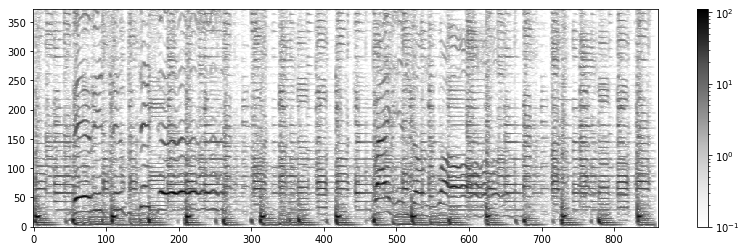

In [3]:
fft_len = 2048
hop_size = 256
max_bin = int(round(4000. * fft_len / fs))

spec = fmp.stft_mag(snd, fft_len, hop_size)[0:max_bin,:]
fmp.plot_spectrogram(spec, cmap='Greys')

Find points of local maxima in a rectangular region: "2D peak picking"

<img src="images/spec_local_max.png" width=200>

<font color=red>__Whiteboard__</font>: Local maxima

Here is an example, with:
- $2 \tau = 60 $ samples or $.7$ seconds
- $2 \kappa = 40 $ bins or $430$ Hz

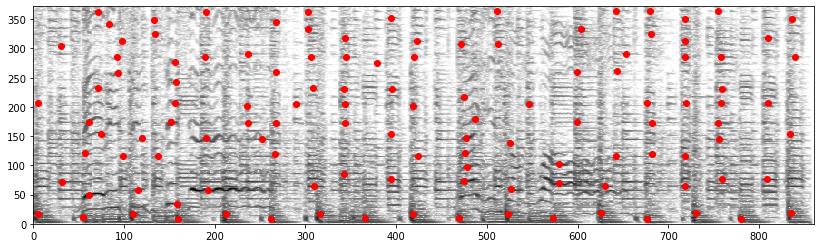

In [4]:
width = 60  # = int(round(.7 * fs / hop_size))
height = 40  #  = int(round(430. * fft_len / fs)) 
points = fmp.make_constellation(snd, fft_len, hop_size, max_bin, width, height)

def show_spec_and_points(spec, points, show_spec=True):
    if show_spec:
        fmp.plot_spectrogram(spec, cmap='Greys', colorbar=False)
    plt.plot(points[:,0], points[:,1], 'ro')
    plt.xlim(0, spec.shape[1])
    plt.ylim(0, spec.shape[0])

plt.figure()
show_spec_and_points(spec, points)

### Neighborhood size

In [5]:
@interact(filt_sz=(2,14))
def show_points(filt_sz):
    filt = np.array((6,4)) * filt_sz
    points = fmp.make_constellation(snd, fft_len, hop_size, max_bin, filt[0], filt[1])

    txt = f'Time span: {filt[0]*hop_size/fs:.2f} sec ({filt[0]} samples)\n'
    txt += f'Freq span: {filt[1]*fs/fft_len:.0f} Hz ({filt[1]} bin)\n'
    txt += f'Num peaks: {points.shape[0]}'
    plt.figure()
    show_spec_and_points(spec, points)
    plt.text(600, 450, txt, fontsize=12)
    plt.show()

interactive(children=(IntSlider(value=8, description='filt_sz', max=14, min=2), Output()), _dom_classes=('widg…

### Robustness

Original audio

In [6]:
ipd.Audio("audio/superstition_orig.wav")

__Equalization__ (i.e., bad speaker or telephone)

In [7]:
ipd.Audio("audio/superstition_eq.wav")

__Noise__ (loud location)

In [8]:
ipd.Audio("audio/superstition_noise.wav")

__Reverb__ (speakers in large space)

In [9]:
ipd.Audio("audio/superstition_reverb.wav")

In [10]:
@interact(v=(1,3), orig=False)
def show_points(v=1, orig=False):
    if orig:
        v = 0
    version = ("orig", "eq", "noise", "reverb")[v]
    snd = fmp.load_wav("audio/superstition_%s.wav" % version)
    spec = fmp.stft_mag(snd, fft_len, hop_size)[0:max_bin,:]
    points = fmp.make_constellation(snd, fft_len, hop_size, max_bin)
    plt.figure()
    show_spec_and_points(spec, points)
    plt.title(version, fontsize=20)
    plt.show()

interactive(children=(IntSlider(value=1, description='v', max=3, min=1), Checkbox(value=False, description='or…

What about playing the song slower or faster?

### Matching

Back to our peaks... or "Constellation"

In [11]:
points = fmp.make_constellation(snd, fft_len, hop_size, max_bin) 

@interact(show_spec=True)
def show_points(show_spec):
    plt.figure()
    show_spec_and_points(spec, points, show_spec)
    plt.show()

interactive(children=(Checkbox(value=True, description='show_spec'), Output()), _dom_classes=('widget-interact…

- Concatenation of many songs $\rightarrow$ Database
- We call the database $\mathcal{D}$ and the constellation map $\mathcal{C(D)}$

<font color=red>__Whiteboard__</font>: Dictionary

A query is a small fragment of audio recording. For example:  
This is a 1.5 second "time slice" of the above audio:

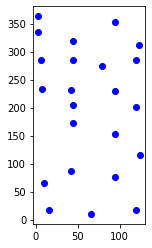

In [12]:
points = fmp.make_constellation(snd, fft_len, hop_size, max_bin)
query = fmp.constellation_slice(points, 300, 429)

plt.figure(figsize=(2, 4))
plt.plot(query[:,0], query[:,1], 'bo');

- This small bit of audio is the query $\mathcal{Q}$ 
- The constellation map of the query is $\mathcal{C(Q)}$

Goal: To find the location of the query fragment in the constellation.

Process:
- shift $\mathcal{C(Q)}$ along time axis of $\mathcal{C(D)}$
- count matching points at each time offset $\rightarrow$ score
- highest scoring shift amount is query match location

Formally:
$$\Delta_{\mathcal{C}}[m] = [m + \mathcal{C(Q)}] \cap \mathcal{C(D)} $$

where $m + \mathcal{C(Q)}$ is a shift of all points in $\mathcal{C(Q)}$ by $m$ time steps.

The best shift (and match location) is:
$$m = \mathrm{argmax} \Delta_{\mathcal{C}}[m]$$

In [13]:
@interact(pos=(0,800, 25))
def slide_demo(pos=0):    
    shifted = query[:,0] + pos
    plt.figure(figsize=(10, 5))
    plt.gcf().add_axes((0,.35,1,.5))
    show_spec_and_points(spec, points, False)
    plt.plot(shifted, query[:,1], 'bo')
    plt.gcf().add_axes((0,0,1,.25))
    match_score = fmp.slide_match(points, query)
    match_score[pos+1:] = 0
    plt.plot(match_score)
    plt.xlim(0, spec.shape[1])
    plt.ylim(0, 25)
    plt.show()

interactive(children=(IntSlider(value=0, description='pos', max=800, step=25), Output()), _dom_classes=('widge…

Test of "altered query" against database:

In [14]:
@interact(v=(0,3), show_q=True)
def show_points(v=0, show_q=True):
    # create alternate queries
    version = ("orig", "eq", "noise", "reverb")[v]
    snd = fmp.load_wav("audio/superstition_%s.wav" % version)
    spec = fmp.stft_mag(snd, fft_len, hop_size)[0:max_bin,:]
    alt_pts = fmp.make_constellation(snd, fft_len, hop_size, max_bin)
    query = fmp.constellation_slice(alt_pts, 300, 429)
    
    match_score = fmp.slide_match(points, query)
    shifted = query[:,0] + np.argmax(match_score)

    plt.figure(figsize=(10, 5))
    plt.gcf().add_axes((0,.35,1,.5))
    show_spec_and_points(spec, points, False)
    plt.title(version, fontsize=20)
    if show_q:
        plt.plot(shifted, query[:,1], 'bo')

    plt.gcf().add_axes((0,0,1,.25))
    plt.plot(match_score)
    plt.xlim(0, spec.shape[1])
    plt.ylim(0, 30)
    plt.show()

interactive(children=(IntSlider(value=0, description='v', max=3), Checkbox(value=True, description='show_q'), …

To match a query against many songs:
- Database is a concatenation of many song constellations.
- Keep track of _time-offset_ per song in the database.

## Query Optimization

<font color=red>__Whiteboard__</font>: Inverted lists

- Compute a hash value $h$ for each constellation point $(n,k)$.
  - Finite set of $h \in \mathcal{H}$
  - Usually $h$ is a fixed-length binary number.
- Create an set of __inverted lists__ $L(h) = \lbrace l_1, l_2, \dots \rbrace$ for each $h$
  - $l$ is the timestamp of the point $(n,k)$. i.e., $l=n$.

Database example:

<img src="images/hash_database.png" width=400>

Query example:

<img src="images/hash_query.png" width=130>

- Queries are small (compared to Database).
  - small # of points
  - small subset of $\mathcal{H}$

To find the optimal query match (i.e. the shift amount):
- for each query point $(n,h)$:
  - compute $m = l - n$ for each $l \in L(h)$ of the database.
- most occuring $m$ is the optimal shift amount and therefore, the match location.

<img src="images/hash_search.png" width=400>

### Initial implementation
For a first implementation, use a really simple hash function: $h = k$.  
So $\mathcal{H} = [0:K-1]$ - one value per frequency bin.

Optimization savings:
- $N$: database items (very large)
- $M$: query items (small)
- $L$: number of hash values $\vert \mathcal{H} \vert$

Assuming $N$ items are spread evenly over all inverted lists, each list $L(h)$ contains roughly $N/L$ items.

Search complexity is:
$${M \cdot N \over L} $$

compared to 

$${M \cdot N} $$

### Implementation example

- Set up the database. 
- Load some songs.

In [15]:
db = fmp.FingerprintDB()
db.add("audio/beatles_magical_mystery_tour.wav")
db.add("audio/brahms_hungarian_5.wav")
db.add("audio/beethoven_5_1_dudamel.wav")

adding audio/beatles_magical_mystery_tour.wav
adding audio/brahms_hungarian_5.wav
adding audio/beethoven_5_1_dudamel.wav


In [16]:
print('songs:')
print('\n'.join(db.song_names))
print(f'feature rate: {db.ff()}')
print(f'song locations: {db.song_locs}')

songs:
audio/beatles_magical_mystery_tour.wav
audio/brahms_hungarian_5.wav
audio/beethoven_5_1_dudamel.wav
feature rate: 86.1328125
song locations: [0, 14197, 26298]


In [17]:
for h in sorted(db.hash_list):
    print(f'{h}:', db.hash_list[h])

0: [15264, 15298, 16357, 17237, 17280, 17370, 17474, 17562, 17661, 17701, 18567, 18638, 18763, 18951, 19038, 21093, 23347, 23395, 24149, 24292, 24442, 24567, 25463, 25601, 25668, 25870]
3: [23892, 24975]
5: [460, 689, 940, 1003, 12551]
6: [5699, 10277, 11297, 12850, 16819, 28780, 35980, 42634, 42743, 42857, 49018, 49126, 49268, 49348, 49460, 49573, 52122, 52168, 65415]
7: [128, 1868, 3689, 5572, 7599, 8228, 8304, 8383, 10094, 11144, 14364, 18139, 18230, 18813, 22432, 24351, 24483, 26518, 30125, 30743, 33691, 38038, 38293, 38483, 41246, 43115, 46216, 46300]
8: [316, 376, 810, 3613, 4096, 4171, 4705, 5144, 6629, 7541, 8153, 8865, 8902, 8947, 9410, 9626, 17157, 18266, 18301, 18338, 18679, 23781, 23840, 24224, 25120, 25250, 25317, 26579, 26623, 28131, 28934, 29042, 30029, 31192, 31383, 32493, 34128, 35502, 35556, 35596, 38709, 45256, 46422, 52212, 54530, 56235, 57724, 57761, 59325, 59678, 60638, 62403]
9: [1064, 1137, 1558, 2053, 2117, 2551, 3794, 3854, 4280, 4323, 4581, 4642, 4767, 4827, 

Load a previously constructed database.

In [18]:
import pickle
DB_FILEPATH = "data/fpdb.pickle"

# create the database:
# import glob
# files = sorted(glob.glob("/Users/eran/dev/audio/*.wav"))
# fmp.make_fingerprint_db(files, DB_FILEPATH)
    
# load the database:
db = pickle.load(open(DB_FILEPATH, 'rb'))

Stats of this database:

num songs: 69
total duration: 224.9 minutes
num hash values:399
num items: 153637
ave hash list length: 385.0551378446115 items


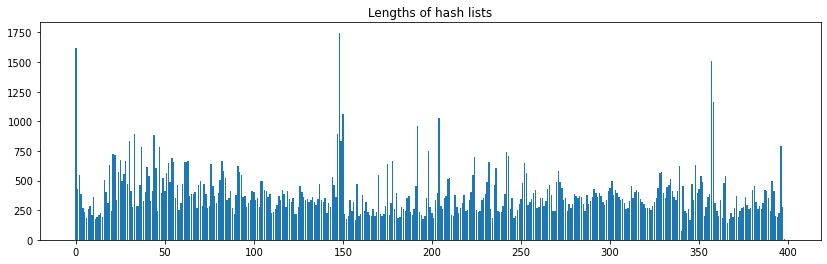

/Users/eran/dev/audio/106_french_suite_no1_in_d_minor_bwv812__6_gigue.wav
/Users/eran/dev/audio/avril_lavigne_knockin_on_heavens_door.wav
/Users/eran/dev/audio/bach__2part_invention_8_in_f_bwv_779.wav
/Users/eran/dev/audio/bach_invention_8_in_f_major_newer_version_cory_hall_pianistcomposer.wav
/Users/eran/dev/audio/beatles_a_day_in_the_life.wav
/Users/eran/dev/audio/beatles_across_the_universe.wav
/Users/eran/dev/audio/beatles_all_you_need_is_love.wav
/Users/eran/dev/audio/beatles_baby_youre_a_rich_man.wav
/Users/eran/dev/audio/beatles_because.wav
/Users/eran/dev/audio/beatles_being_for_the_benefit_of_mr_kite.wav
/Users/eran/dev/audio/beatles_blue_jay_way.wav
/Users/eran/dev/audio/beatles_carry_that_weight.wav
/Users/eran/dev/audio/beatles_come_together.wav
/Users/eran/dev/audio/beatles_dig_a_pony.wav
/Users/eran/dev/audio/beatles_dig_it.wav
/Users/eran/dev/audio/beatles_fixing_a_hole.wav
/Users/eran/dev/audio/beatles_flying.wav
/Users/eran/dev/audio/beatles_for_you_blue.wav
/Users/era

In [19]:
print(f'num songs: {len(db.song_names)}')
print(f'total duration: {db.sample_offset/db.ff()/60:.1f} minutes')

list_lengths = np.array([len(db.hash_list[x]) for x in db.hash_list])
print(f'num hash values:{len(list_lengths)}')
print(f'num items: {np.sum(list_lengths)}')
print(f'ave hash list length: {np.mean(list_lengths)} items')

plt.bar(np.arange(len(list_lengths)), list_lengths)
plt.title('Lengths of hash lists')
plt.show();

# song names:
for s in db.song_names:
    print(s)

Let's run some queries!

In [20]:
import os
# os.system("open -a Audacity") 

In [21]:
snd = fmp.load_wav("audio/query1.wav")
ipd.Audio(snd, rate=fs)

In [22]:
results, max_pts = db.query(snd, 3)

for r in results:
    print(f'name:{r[0]}\n  score:{r[2]} at:{r[1]:.3f} seconds of song')

top = results[0]
ipd.Audio(fmp.load_wav(top[0], top[1], top[1] + 10), rate = fs)

name:/Users/eran/dev/audio/guns_n_roses_knockin_on_heavens_door.wav
  score:18 at:102.969 seconds of song
name:/Users/eran/dev/audio/guns_n_roses_knockin_on_heavens_door.wav
  score:13 at:102.980 seconds of song
name:/Users/eran/dev/audio/106_french_suite_no1_in_d_minor_bwv812__6_gigue.wav
  score:3 at:103.213 seconds of song


FileNotFoundError: [Errno 2] No such file or directory: '/Users/eran/dev/audio/guns_n_roses_knockin_on_heavens_door.wav'

### Further Optimization

The current hashing scheme is not that good. 
- $L=400$
- To improve ${M \cdot N \over L}$, we must increase $L$.

<font color=red>__Whiteboard__</font>: Improving hashing

Ideas:
- Increase FFT size.
  - Robustness would suffer.
- Define "item" as a pairs of peaks
  - anchor point (first peak)
  - fanout zone $T = (n_z, k_z)$ to find a number of secondary peaks near anchor
  - do this for all peaks
<img src="images/hash_pairs.png" width=500>

Now, the hash function is:
$$h = (k_0, k_1, n_1 - n_0)$$
The hash space $\mathcal{H}$ is much larger:
$$ \vert \mathcal{H} \vert = K \cdot K \cdot n_z$$

The number of "points" (or items) has also increased:


- $F$ (fanout): average number of pairs formed given target zone $T = (n_z, k_z)$
- $N_{pairs}$ (database size) $ = N \cdot F$  
- $M_{pairs}$ (query size) $ = M \cdot F$

But the number of hash lists has increased dramatically:
- $L_{pairs} = L \cdot L \cdot L$ (approx, assuming $n_z \simeq K$)

So:

$$ { M_{pairs} \cdot N_{pairs} \over L_{pairs} } = { M \cdot F \cdot N \cdot F\over L \cdot L \cdot L} = { F^2 \over L^2 } \cdot {M \cdot N \over L}$$

If $F=10$ and $L=1000$:
- the computational speed improvement is $10,000$

- the data storage requirement increase by a factor of $F=10$

## Audio Matching
### Goal

Given:
- A database of audio recordings 
- A _short audio fragment_ (the query) 

Retrieve all excerpts from the recordings that are _musically_ similar to the query.

The constellation / fingerprint system will not work very well. It is too specific to the audio characteristics of the recording:

In [ ]:
snd1 = fmp.load_wav("audio/beethoven_5_1_bernstein.wav", 19.5, 28)
ipd.Audio(snd1, rate=fs)

In [ ]:
snd2 = fmp.load_wav("audio/beethoven_5_1_dudamel.wav", 0, 7)
ipd.Audio(snd2, rate=fs)

In [ ]:
def plot_spec_and_constellation(snd):
    spec = fmp.stft_mag(snd, fft_len, hop_size)[0:max_bin,:]
    points = fmp.make_constellation(snd, fft_len, hop_size, max_bin)
    show_spec_and_points(spec, points)
    
plt.figure()
plt.subplot(2,1,1)
plot_spec_and_constellation(snd1)
plt.subplot(2,1,2)
plot_spec_and_constellation(snd2)

### Chromagrams
Instead, we use chroma vectors, with CENS smoothing / downsampling:

In [ ]:
def make_cens(snd):
    fft_len = 4096
    cens_filt_len = 11
    cens_ds = 3
    chroma = fmp.make_chromagram(snd, fs, fft_len, fft_len//2)
    return fmp.cens(chroma, cens_filt_len, cens_ds)

fmp.plot_two_chromas(make_cens(snd1), make_cens(snd2))

### Strategy

- Query is a short (several seconds) chromagram (Sequence X).
- Audio database is a concatenation of many individual chromagrams (Sequence Y - very long).

<img src="images/matching_x_y.png" width=600>

- Idea 1: Slide X across Y, looking for a good match.
- Idea 2: Create a cost matrix between X and Y, and find good looking diagonal paths.

<font color=red>__Whiteboard__</font>: Cost Matrix

Cost Matrix:
$$\mathbf{C}[n,m] = 1 - \langle x_n, y_m \rangle$$


Example:
- Query is first 21 bars of Beethoven's 5th
- Database is entire piece (Dudamel recording)

In [ ]:
query = fmp.load_wav("audio/beeth5_query2.wav")
database = fmp.load_wav("audio/beethoven_5_1_dudamel.wav")
ipd.Audio(query, rate=fs)

Chromagrams for Query and Database.

In [ ]:
fmp.plot_two_chromas(make_cens(query), make_cens(database))

Cost Matrix for Query and Chromagram.

Can you spot the diagonal paths? Need to zoom in.

In [ ]:
cost = 1 - np.dot(make_cens(query).T, make_cens(database))
plt.imshow(cost, origin='lower', aspect='auto', cmap='gray');
plt.xlabel("Database")
plt.ylabel("Query")
plt.colorbar();
# plt.xlim(0, 500)
# plt.xlim(800,1200)

### DTW for finding paths

- Diagonals are not perfectly straight lines (tempo differences)
- This motivates using Dynamic Time Warping
- But we don't want to align corners
- And we want to find (potentially) many paths


<font color=red>__Whiteboard__</font>: Multipath DTW

Recall in classic DTW, calculate $\mathbf{D}$ (accumulated cost matrix) from $\mathbf{C}$:

$$\mathbf{D}[n,1] = \sum_{k=1}^n \mathbf{C}[k,1] \text{ for } n \in[1:N] $$
$$\mathbf{D}[1,m] = \sum_{k=1}^m \mathbf{C}[1,k] \text{ for } m \in[1:M] $$
$$\mathbf{D}[n,m] = \mathbf{C}[n,m] + \mathrm{min}
\begin{cases}
\mathbf{D}[n-1,m] \\
\mathbf{D}[n,m-1] \\
\mathbf{D}[n-1,m-1] \\
\end{cases}$$

For this variant, replace the initialization of the first row of $\mathbf{D}$ with:
$$\mathbf{D}[1,m] = \mathbf{C}[1,m]$$

This removes any penalty from "starting in the middle of sequence Y".

Instead of looking at $\mathbf{D}[N,M]$ for the total accumulated cost of the optimal warping path, examine the entire final row  $\mathbf{D}[N,m] \text{ for } m \in[1:M]$.

The optimal path _ends_ at the timestep:
$$b^* = \underset{b \in[1:M]}{\operatorname{argmin}}\mathbf{D}[N,b]$$


From the example above, this is $\mathbf{D}$:

In [ ]:
D, matches = fmp.dtw_match(cost, 3)
plt.imshow(D, origin='lower',  aspect='auto', cmap='gray');
plt.colorbar();

The last row of $\mathbf{D}$ (or the top row in the above plot) is called the __DTW matching function__:

$$\Delta_{\text{DTW}}[m] = \mathbf{D}[N,m]$$

In [ ]:
D, matches = fmp.dtw_match(cost, 3)
top_row = D[-1,:]
best = np.argmin(top_row)
plt.plot(top_row);
plt.plot(best, top_row[best], 'ro')
plt.ylabel('cost', fontsize=15)
plt.show()

This shows the accumulated cost for ending at each time step. The lowest cost point $b^*$ is the _end_ of the optimal matching subsequence.

Following the backtracking matrix leads to $a^*$, the beginning of the optimal matching sequence.

Or, for sequence $X[n], n \in [1:N]$ (the query), the optimal matching subsequence of $Y$ (the database) is $Y[a^*:b^*]$.

### Multiple Matches

We can find multiple matches as well:
- find the lowest cost (argmin).
- squash out surrounding area.
- repeat

In [ ]:
peaks = fmp.find_top_n_peaks(-top_row, 3, 200)
@interact(n=(0,6))
def show_n_matches(n=0):
    x = top_row.copy()
    sq = n // 2
    pk = (n-1) // 2 + 1
    for i in range(sq):
        p = peaks[i]
        s = max(p - 100, 0)
        e = min(p + 100, len(x) - 1)
        x[s:e] = np.max(x)
    plt.plot(x)
    pks = peaks[:pk]
    plt.plot(pks, top_row[pks], 'ro')
    plt.ylim(0, 35)
    plt.show()

The quality of the match is related to the cost. So we can return a google-style ordered list of matches.

### Multipiece Database Example

Create the database:

In [ ]:
mdb = fmp.MatchDB()
mdb.add("audio/beethoven_5_1_bernstein.wav")
mdb.add("audio/brahms_hungarian_5.wav")
mdb.add("audio/beethoven_5_1_dudamel.wav")
mdb.add("audio/beethoven_5_1_morton.wav")
mdb.add("audio/beatles_magical_mystery_tour.wav")

The query:

In [ ]:
query = fmp.load_wav("audio/beeth5_query.wav")
ipd.Audio(query, rate=fs)

The resulting matches:

In [ ]:
results, match_fn = mdb.query(query, 8, True)

A view of the cost function for the whole database:

In [ ]:
@interact(bounds=False)
def show_cost(bounds):
    plt.plot(match_fn)
    if bounds:
        _min, _max = np.min(match_fn), np.max(match_fn)
        plt.vlines(mdb.song_locs, _min, _max, 'r')
        for i,s in enumerate(mdb.song_names):
            txt = s.split('/')[1].split('.')[0]
            plt.text(mdb.song_locs[i], _max * .8 + 3*(i%2), txt)
    plt.show();

In [ ]:
@interact(r=(0,len(results)-1))
def play_result(r=0):
    r = results[r]
    print(f'{r[0]}\nspan: {r[1]:.1f} to {r[2]:.1f} seconds\ncost: {r[3]:.2f}')
    snd = fmp.load_wav(r[0], r[1], r[2])
    return ipd.Audio(snd, rate = fs)

## Preparation for Lab 8

In Lab 8, we will create song databases using music contributed by all students. Find __two songs__ (ideally < 10 minutes each) and convert them to mono 22k WAV file using Audacity. Name them `<artist>_<songname>.wav`
